In [1]:
!pip install --upgrade 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: You must give at least one requirement to install (see "pip help install")


In [2]:
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os


In [7]:
data_dir='C:\\Users\\DELL\\OneDrive\\Desktop\\medical_snapchat\\jaffe'

In [8]:
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    expression_map = {
        'AN': 'anger',
        'DI': 'disgust',
        'FE': 'fear',
        'HA': 'happiness',
        'NE': 'neutral',
        'SA': 'sadness',
        'SU': 'surprise'
    }

    for filename in glob.glob(os.path.join(data_dir, '*.tiff')):
        try:
            img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48)) # Resize for consistency
            img = img / 255.0  # Normalize pixel values
            images.append(img)

            # Extract label from filename (e.g., 'KL.AN1.39.tiff' -> 'AN')
            parts = filename.split('.')
            if len(parts) >= 2:
                expression_code = parts[1][:2]  # Take the first two characters after the first dot
                if expression_code in expression_map:
                    labels.append(expression_map[expression_code])
                else:
                    print(f"Warning: Unknown expression code '{expression_code}' in {filename}")
            else:
                print(f"Warning: Could not extract expression code from {filename}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    images = np.array(images).reshape(-1, 48, 48, 1) # Reshape for CNN (height, width, channels)
    labels = np.array(labels)

    # Encode labels to numerical values
    label_encoder = LabelEncoder()
    integer_labels = label_encoder.fit_transform(labels)
    categorical_labels = to_categorical(integer_labels, num_classes=len(expression_map))

    return images, categorical_labels, label_encoder.classes_

In [9]:
images, labels, class_names = load_and_preprocess_data(data_dir)

Training data shape: (170, 48, 48, 1)
Training labels shape: (170, 7)
Testing data shape: (43, 48, 48, 1)
Testing labels shape: (43, 7)
Class names: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']


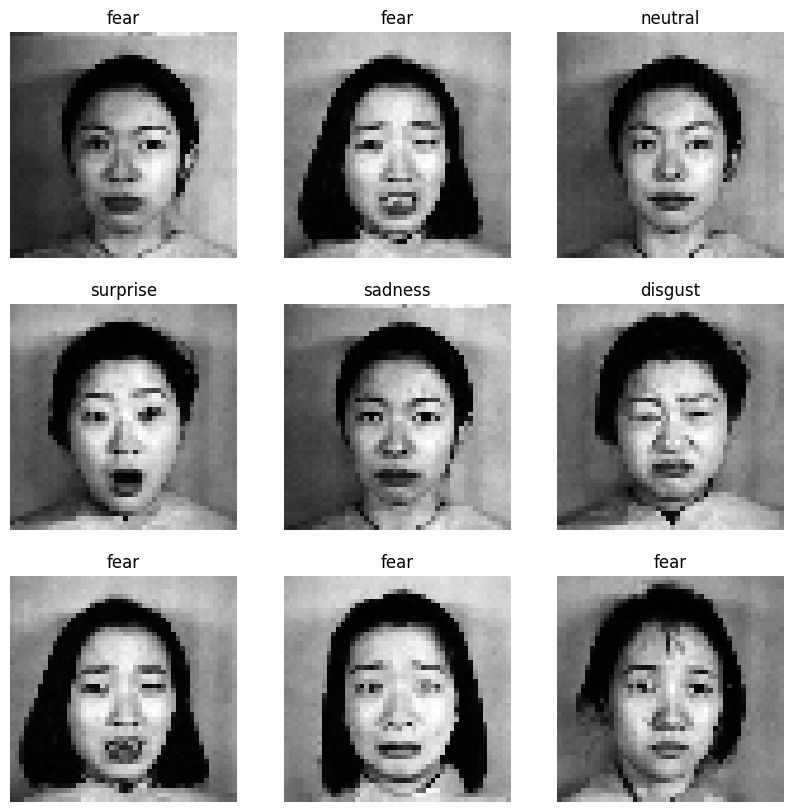

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)
print("Class names:", class_names)

# Visualize a few sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    label_index = np.argmax(y_train[i])
    plt.title(class_names[label_index])
    plt.axis('off')
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [12]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])
    return model

In [13]:
input_shape = (48, 48, 1)
num_classes = len(class_names)
model = create_cnn_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 915,847 (3.49 MB)

 Trainable params: 914,887 (3.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.1908 - loss: 2.7072 - val_accuracy: 0.0588 - val_loss: 1.9812
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.2690 - loss: 2.3811 - val_accuracy: 0.1176 - val_loss: 2.0153
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.3755 - loss: 1.9578 - val_accuracy: 0.1176 - val_loss: 2.0790
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.3729 - loss: 1.8263 - val_accuracy: 0.0588 - val_loss: 2.1503
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.5141 - loss: 1.4303 - val_accuracy: 0.1176 - val_loss: 2.1993
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.4916 - loss: 1.3899 - val_accuracy: 0.1176 - val_loss: 2.2509
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5280 - loss: 1.2636 - val_accuracy: 0.1176 - val_loss: 2.2981
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.6410 - loss: 1.0032 - val_accuracy: 0.1765 - val_loss:

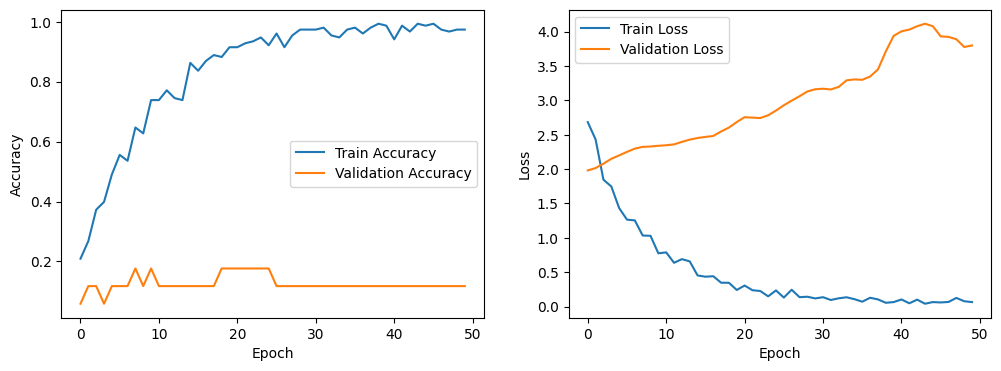

In [14]:
epochs = 50
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    shuffle=True)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Loss: 3.4432
Test Accuracy: 0.1395
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         6
     disgust       0.00      0.00      0.00         6
        fear       0.00      0.00      0.00         7
   happiness       0.14      1.00      0.24         6
     neutral       0.00      0.00      0.00         6
     sadness       0.00      0.00      0.00         6
    surprise       0.00      0.00      0.00         6

    accuracy                           0.14        43
   macro avg       0.02      0.14      0.03        43
weighted avg       0.02      0.14      0.03        43



C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

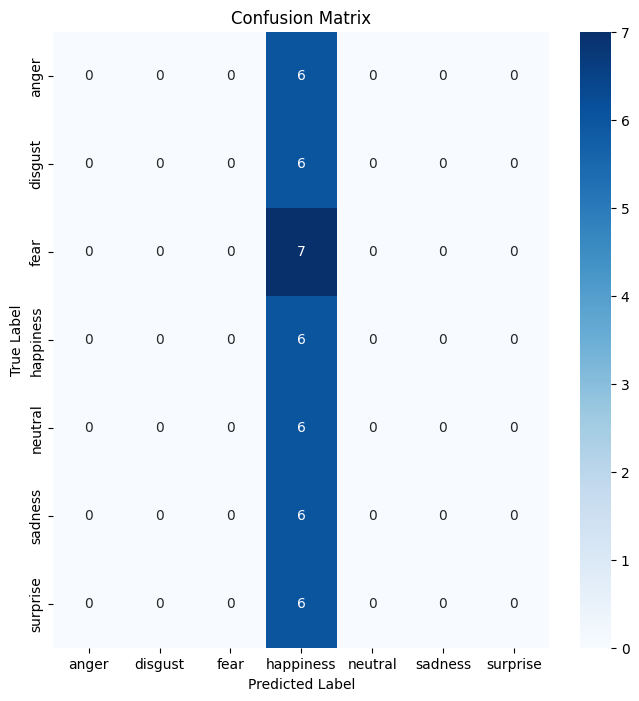

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model.save('jaffe_expression_model.h5')
print("Trained model saved as jaffe_expression_model.h5")

Trained model saved as jaffe_expression_model.h5
